In [76]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Process diamond output

In [2]:
df = pd.read_csv("../gene_hits.tsv", header=0, index_col=0, sep="\t")

# drop the extra header cols
df = df[df["Query accession"]!="Query accession"]

# Create a sample id and read number columns from query accession 
df["Sample ID"] = df["Query accession"].apply(lambda x: x.split(".")[0])
df["Read number"] = df["Query accession"].apply(lambda x: x.split(".")[1])


## Remove where missing gene names

In [3]:
percent_with_names = sum(df["Gene name"].isna()==False)/df.shape[0]

print(round(percent_with_names*100), "percent of hits matched a gene name on uniprot")

# Only keep where we have a gene name
df = df[df["Gene name"].isna()==False]

42 percent of hits matched a gene name on uniprot


## Get metacyc gene names

In [4]:
pathway_1 = pd.read_csv("../database-building/metacyc-nic-deg-1.txt", 
                        header=1, sep="\t")
pathway_2 = pd.read_csv("../database-building/metacyc-nic-deg-2.txt", 
                        header=1, sep="\t")
pathway_3 = pd.read_csv("../database-building/metacyc-nic-deg-3.txt", 
                        header=1, sep="\t")

metacyc_gene_names = set(pathway_1["Gene name"]) | set(pathway_2["Gene name"]) | set(pathway_3["Gene name"])

## Remove where gene names not in metacyc pathways

In [5]:
df = df[df["Gene name"].apply(lambda x: x in metacyc_gene_names)]

In [6]:
df["E-value"] = df["E-value"].astype(float)

In [7]:
df = df.loc[df.groupby("Read number")["E-value"].idxmin()]

# Metadata

In [54]:
metadata = pd.read_csv("../metadata/metadata.csv")
metadata = metadata.set_index("#SampleID")

In [61]:
SRA1_metadata = pd.read_csv("../metadata/PRJNA508385_SRA_metadata.txt")
SRA2_metadata = pd.read_csv("../metadata/PRJNA548383_SRA_metadata.txt")

# This one was formatted really weirdly... csv in a tsv
SRA3_metadata_weird = pd.read_csv("../metadata/PRJNA544061_SRA_metadata.txt")
SRA3_metadata_data = [str(x) for x in SRA3_metadata_weird.index]
SRA3_metadata = [(x.split(",")[0][2:], x.split(",")[5]) for x in SRA3_metadata_data]
SRA3_metadata = pd.DataFrame(SRA3_metadata, columns=["Run","BioSample"])
SRA3_metadata = pd.concat([SRA3_metadata, SRA3_metadata_weird["Sample Name"].reset_index()],
                          axis=1)

# CHANGE THIS WE NEED SAMPLE NAME NOT BIOSAMPLE

SRA_metadata = pd.concat([SRA1_metadata[["Run","Sample Name"]],
                          SRA2_metadata[["Run","Sample Name"]],
                          SRA3_metadata[["Run","Sample Name"]]],
                        axis=0)
SRA_metadata = SRA_metadata.set_index("Sample Name")

In [64]:
metadata["Run"] = SRA_metadata["Run"]

# Get a count per sample

In [73]:
metadata = metadata.reset_index().set_index("Run")

In [74]:
metadata["Hits"] = df.groupby("Sample ID").count()["Query accession"]

In [75]:
metadata

,#SampleID,GroupName,Description,Age,Gender,Ethnicity,Duration of use,Frequency of use,Type of e-cig device,Nicotine concentration ( per milliliter of e-juice),Hits
Run,,,,,,,,,,,
SRR9641808,HNS126_S6,Never Smoker,HNS126_S6,28,Female,Caucasian,NaN,NaN,NaN,NaN,84.0
SRR9641805,HNS127_S7,Never Smoker,HNS127_S7,29,Male,Caucasian,NaN,NaN,NaN,NaN,22.0
SRR9641806,HNS128_S8,Never Smoker,HNS128_S8,23,Female,Caucasian,NaN,NaN,NaN,NaN,224.0
SRR9641807,HNS129_S9,Never Smoker,HNS129_S9,23,Female,Caucasian,NaN,NaN,NaN,NaN,93.0
SRR9641809,HNS130_S10,Never Smoker,HNS130_S10,25,Female,Caucasian,NaN,NaN,NaN,NaN,113.0
...,...,...,...,...,...,...,...,...,...,...,...
SRR9668722,D355_S41,ENDS Dual Smoker,D355_S41,20,Male,Caucasian,8 months,everyday,e-cig that use cartridges and disposable e-cig...,13 - 16 mg,130.0
SRR9668689,D356_S42,ENDS Dual Smoker,D356_S42,21,Female,Caucasian,3 months,everyday,e-cig that use cartridges,1.5 mg,397.0
SRR9668719,D357_S43,ENDS Dual Smoker,D357_S43,42,Female,Caucasian,1.5 years,everyday,Disposable coils,3 - 6 mg,180.0


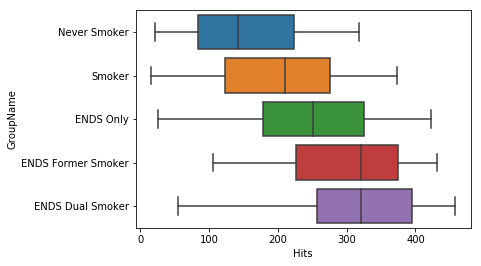

In [78]:
sns.boxplot("Hits",
            "GroupName",
            data=metadata)

## Num of reads
Have to do some cleaning bc I formatted poorly - will address later

In [111]:
with open("num_reads.txt") as f:
    contents = f.readlines()
contents = [content.strip().split("\\t") for content in contents]

In [112]:
num_reads_df = pd.DataFrame(contents, columns=["filepath", "num reads"])
num_reads_df = num_reads_df.replace("", np.NaN)
num_reads_df = num_reads_df[num_reads_df["num reads"].isna()==False]

In [113]:
num_reads_df["Sample"] = num_reads_df["filepath"].apply(lambda x: x.split("/")[-1].strip())
num_reads_df = num_reads_df.set_index("Sample")

In [117]:
metadata["Num reads"] = num_reads_df["num reads"].astype(int)

In [118]:
metadata["Hits per read"] = metadata["Hits"]/metadata["Num reads"]

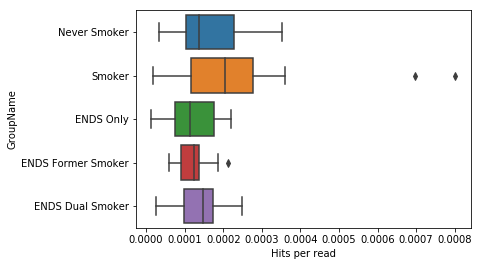

In [119]:
sns.boxplot("Hits per read",
            "GroupName",
            data=metadata)

# Stats

In [120]:
from scipy import stats

In [131]:
never = metadata.loc[metadata["GroupName"]=="Never Smoker", "Hits per read"]
smoker = metadata.loc[metadata["GroupName"]=="Smoker", "Hits per read"]
ENDS = metadata.loc[metadata["GroupName"]=="ENDS Only", "Hits per read"]
ENDS_former = metadata.loc[metadata["GroupName"]=="ENDS Former Smoker", "Hits per read"]
ENDS_dual = metadata.loc[metadata["GroupName"]=="ENDS Dual Smoker", "Hits per read"]

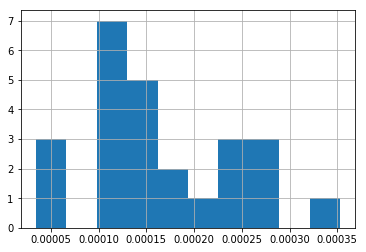

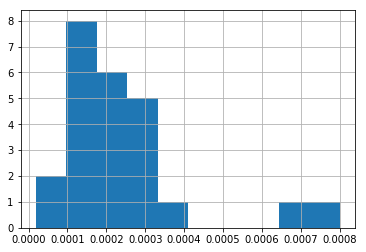

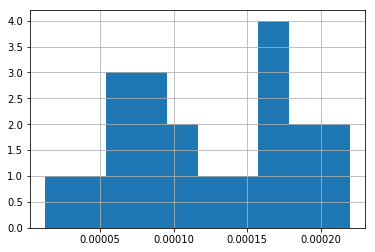

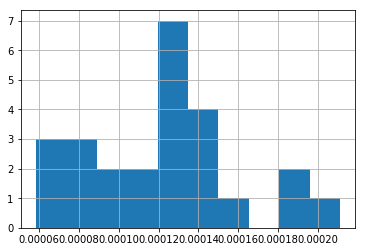

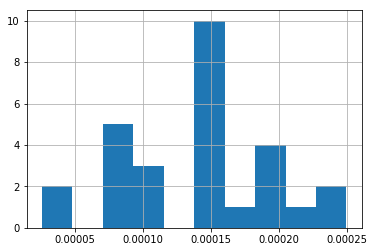

In [134]:
for group in [never, smoker, ENDS, ENDS_former, ENDS_dual]:
    group.hist()
    plt.show()

In [133]:
stats.kruskal(never, smoker, ENDS, ENDS_former, ENDS_dual,
              nan_policy="omit")

KruskalResult(statistic=11.685252375240395, pvalue=0.01985191934429646)